In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data 

In [2]:
adult_train = pd.read_csv("adult-t.tsv", sep = "\t")
adult_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,42.0,4,308770.0,15,10.0,2,1,0,2,1,0.0,0.0,40.0,39,0
1,23.0,4,520231.0,15,10.0,4,10,1,4,0,0.0,0.0,45.0,39,1
2,27.0,4,164924.0,11,9.0,4,3,1,4,1,0.0,0.0,40.0,39,1
3,29.0,6,198286.0,9,13.0,4,10,1,4,0,0.0,0.0,40.0,39,1
4,32.0,4,197505.0,11,9.0,4,1,3,4,0,0.0,0.0,40.0,39,1


In [3]:
adult_train = pd.get_dummies(adult_train, columns=['workclass', 'sex', 'occupation', 'relationship', 'race', 'native-country', 'marital-status'])
adult_train.shape

(10000, 93)

In [4]:
normalize_columns = ['age', 'fnlwgt', 'capital-gain','capital-loss','hours-per-week']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  adult_train[columns] = scaler.fit_transform(adult_train[columns])
normalize(normalize_columns)

In [5]:
X = adult_train[[c for c in adult_train.columns if c != 'target']]
y = adult_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Trying KNN Classifier without HyperParameter tunings

In [6]:
base_clf = KNeighborsClassifier()

In [7]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8137178768137826
Test Accuracy:  0.7385119945573402


In [8]:
base_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### Generate Learning Curve & Validation Curve with default classifier

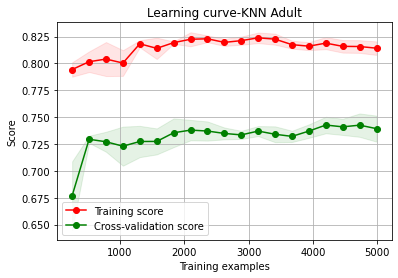

In [9]:
plot_learning_curve(base_clf, "Learning curve-KNN Adult", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

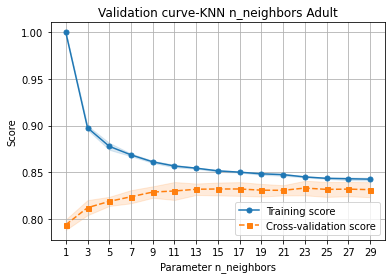

In [10]:
plot_validation_curve(base_clf, X_train, y_train, 'n_neighbors', np.arange(1, 30, 2), cv=4, n_jobs=-1, scoring=make_scorer(balanced_accuracy_score), title="Validation curve-KNN n_neighbors Adult")

### Conducting GridSearch to obtain best HyperParameters

In [11]:
param_grid = {
    'n_neighbors': np.arange(1, 200, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [12]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191]),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [13]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

In [14]:
grid_search.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='distance')

In [15]:
grid_search.best_score_

0.7506820142499058

### Generating Learning Curve with tuned Hyperparameters

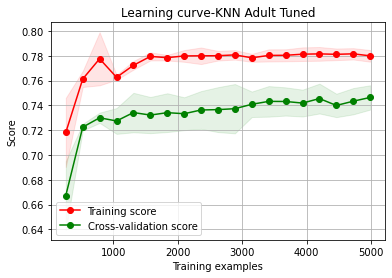

In [20]:
plot_learning_curve(KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='uniform'), "Learning curve-KNN Adult Tuned", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [21]:
#best_params = grid_search.cv_results_['params'][np.argmax(grid_search.cv_results_['mean_test_score'])]
best_clf = KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='uniform')
best_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'uniform'}

In [22]:
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7855603752106594
Test Accuracy:  0.7413590380690389
